In [ ]:
# import os
import cv2

import numpy as np
import time

import tensorflow as tf

import matplotlib.pyplot as plt

import queue

首先引入所需要的库，然后将模型文件（tflite）载入到一个TensorFlow中构建一个interpreter实例

In [2]:
model_path = "/Users/sedecim/Downloads/multi_person_mobilenet_v1_075_float.tflite" 

In [3]:
interpreter = tf.lite.Interpreter(model_path = model_path)

令interpreter根据载入的模型为其中的参数（张量）分配空间

In [4]:
interpreter.allocate_tensors()

使用 get_input(output)_details 方法可以查询到模型输入与输出的格式；这一对函数返回的值是一个列表，表中的每个元素描述了这个输入或输出张量的情况；其中 index 字段的数字代表了使用 get或set_tensor 方法时传给interpreter的索引参数值，此外还有关于数据类型和尺寸的信息

In [5]:
input_detail = interpreter.get_input_details()
input_detail

[{'name': 'sub_2',
  'index': 97,
  'shape': array([  1, 353, 257,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [6]:
output_detail = interpreter.get_output_details()
output_detail

[{'name': 'float_heatmaps',
  'index': 93,
  'shape': array([ 1, 23, 17, 17], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'float_short_offsets',
  'index': 96,
  'shape': array([ 1, 23, 17, 34], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'float_mid_offsets',
  'index': 94,
  'shape': array([ 1, 23, 17, 64], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'float_segments',
  'index': 95,
  'shape': array([ 1, 23, 17,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

这里我们读入一张用于测试的图片，可以看到通过OpenCV读入后，它的尺寸为 (478, 333, 3) 即478 * 333 像素、三通道色彩，并且其取值为0-255的 int8类型

In [7]:
test_img = "/Users/sedecim/Code/创新项目/pose/MobilePose-pytorch/resources/5.png"
# test_img = "/Users/sedecim/Downloads/F1F7E31DD1B3F6A52F852F1E7E55269C.jpeg"

In [8]:
img = cv2.imread(test_img);

openCV的imread函数读入的图像，rgb顺序不正确，需要先进行修正才与网络和pyplot使用的顺序相当；顺序调整的方法见下面的代码

In [9]:
img.shape

img_transposed = np.zeros(img.shape,"uint8");
img_transposed[:,:,0] = img[:,:,2]
img_transposed[:,:,1] = img[:,:,1]
img_transposed[:,:,2] = img[:,:,0]

img = img_transposed

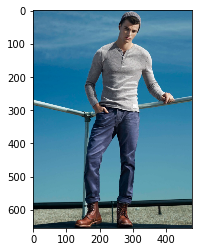

In [10]:


plt.imshow(img)

In [11]:
np.shape(img)

(655, 478, 3)

In [12]:
img.shape

(655, 478, 3)

模型本身需要的输入格式为 (1, 353, 257, 3) 类型为取值\[-1,1\]的float32；因此我们需要对取到的图像做预处理

* 将图像缩放调整到 353 * 257 尺寸
* 将图像格式转换为 float32
* 将图像中的元素除以 255/2 再减1从而正规化数据取值
* 扩展一个维度

In [13]:
fitted_img = np.zeros_like(img)

In [14]:
fitted_img = cv2.resize(img, (257,353))

In [15]:
fitted_img.shape

(353, 257, 3)

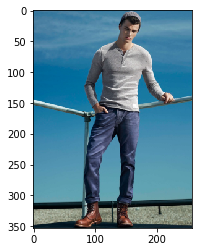

In [16]:
plt.imshow(fitted_img)

In [17]:
fitted_img[0][0]

array([ 53, 115, 153], dtype=uint8)

In [18]:
expanded_img = np.expand_dims(fitted_img, axis = 0)

In [19]:
expanded_img.shape

(1, 353, 257, 3)

In [20]:
expanded_img = expanded_img.astype('float32')
expanded_img = expanded_img/ (255/2)
expanded_img = expanded_img - 1

至此输入图像的预处理进行完毕，实际情况中还应该记录图像预处理过程中涉及到的参数，以便通过我们的算法得到的解可以被映射回问题空间中去；

接下来我们将预处理的结果装入到interpreter中，使用通过get_input_details得到的输入张量索引以及 set_tensor 方法完成这个步骤

In [21]:
print(input_detail[0]['index'])
interpreter.set_tensor(input_detail[0]['index'], expanded_img)

97


在完成输入数据的装填后，通过 invoke 方法“唤醒”interpreter *(whatever that means)*

In [22]:
interpreter.invoke()

invoke 运行结束即意味着数据以及流过神经网络模型，接下来开始读取输出的数据；

输出数据通过 get_tensor 方法读取，与set方法相同，我们同样需要张量的索引值来定位输出数据

In [23]:
output_data = interpreter.get_tensor(output_detail[0]['index'])

In [24]:
output_data.shape

(1, 23, 17, 17)

## 网络的输出数据总结

invoke调用结束之后，即可以从网络中读出输出数据，其格式在output_detail中已经可以初步看到；网络有四个输出张量，均为float32格式，它们分别是：

1. heatmaps (1 * 23 * 17 * 17)
2. short_offsets (1 * 23 * 17 * 34)
3. mid_offsets (1 * 23 * 17 * 64)
4. segements (1 * 23 * 17 * 1)

其中第一维均没有意义，算是一个包装，第二维和第三维是空间信息，23 * 17 即是0.75尺寸网络输出图像的精度，23 = ( 353 - 1 ) / 16 + 1(纵轴，横轴同理)；这里的16概念上叫做stride，在js版本的源码里是一个可以取8/16/32的一个关于网络结构的参数，由于在这里网络结构是固定的，可以算出stride总是取16；第四维每种输出都不同：

1. heatmaps
有17个取值，分别代表不同的身体部位，heatmaps\[0,:,:,part\]是一个概论分布图，其值越大代表越可能是对应的部位，这张图的数据没有归一化，取值范围大约是-20到10左右；分析js版本的源代码可以看出取值大于0.5代表接近所描述的部位，“接近”从论文来说是指位于具体的关键点周围半径30像素的圆内。

2. short_offsets
有34个取值，即 17 * 2 种；short_offsets是论文中说的 "short range offset"，js源码中的“offset”;是一个向量，意义是对于每一个“接近（如上文提到的定义）”准确的关键点的点，偏移向量指向关键点。offset = (x,y) = (short_offset\[0,:,;,17 + part\], short_offset\[0,:,:,part\])

3. mid_offsets
有64个取值，是 (17 - 1) * 2 * 2 的含义；由于人体的结构被定义为17个关键点构成，以鼻尖为根的一颗有向树，所以其中有17 - 1 条边，对于每一条边，有一组向量，向量是二维的，因此再乘二，又由于有向边的正向和反向都定义了向量，所以再乘二；
结果就是64被分成前32和后32； **前32是正向边， 后32是反向边**，每一组内又有前16个为总左边，后16位横坐标

4. segment
代表检测出人体的形状

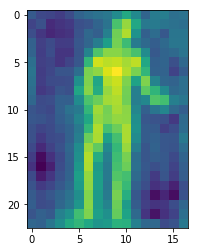

In [25]:
output_segemtns = interpreter.get_tensor(output_detail[3]['index'])
plt.imshow(output_segemtns[0,:,:,0])

In [26]:
heatmap_1 = np.mat(np.zeros((23,17)))
print(heatmap_1.shape)

(23, 17)


In [27]:
def extract_heatmap(index):
    heatmap = np.mat(np.zeros((23,17)))
    for i in range(23):
        for j in range(17):
            heatmap[i,j] = output_data[0][i][j][index]
    return heatmap

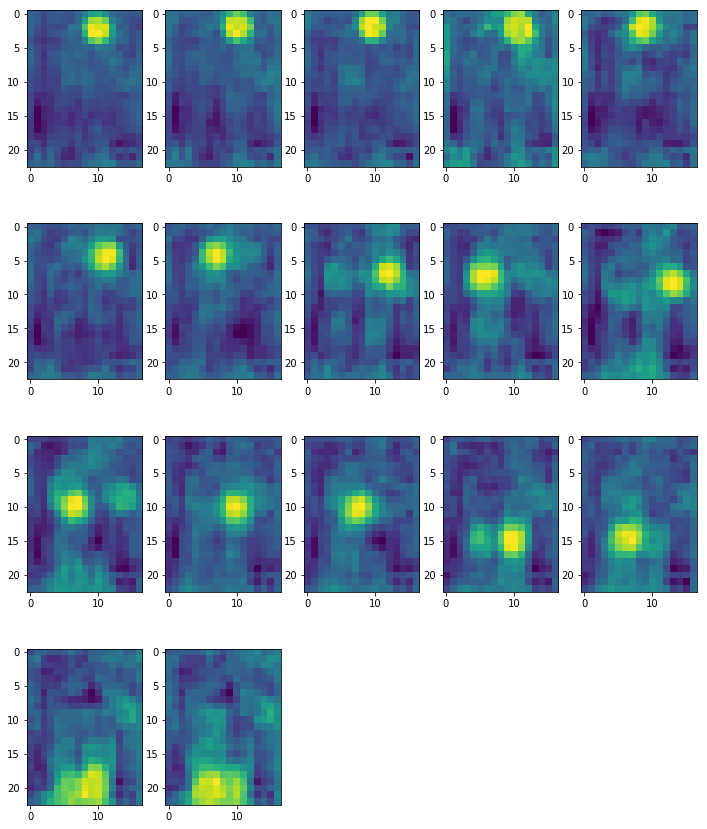

In [28]:
plt.figure(figsize=(12,15))

for i in range(17):
    plt.subplot(4,5,i+1)
    plt.imshow(extract_heatmap(i))

plt.show()

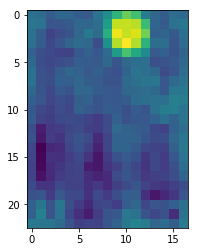

In [29]:
plt.imshow(extract_heatmap(1))

In [30]:
output_offset = interpreter.get_tensor(output_detail[1]['index'])

In [31]:
output_offset.shape

(1, 23, 17, 34)

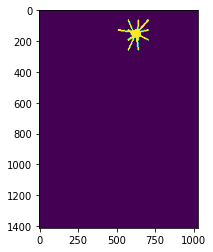

In [32]:
def offset_field_img(part, score_threshold):
    part_offset_img = np.zeros(fitted_img.shape,"uint8")
    for i in range(23):
        for j in range(17):
            if(output_data[0,i,j,part] > score_threshold):
                x_base = j * 16 # 16 is the default stride setting
                y_base = i * 16
                y_tar = y_base + int(output_offset[0,i,j,part])
                x_tar = x_base + int(output_offset[0,i,j,part + 17])
                cv2.line(part_offset_img, (x_base,y_base),(x_tar,y_tar),(250,250,250),2)
                cv2.circle(part_offset_img, (x_tar,y_tar), 3, (250,250,250),3)
    return part_offset_img

plt.imshow(cv2.resize(offset_field_img(0,0.5)[:,:,0],(257*4,353*4)))
# plt.imshow(offset_field_img(10))


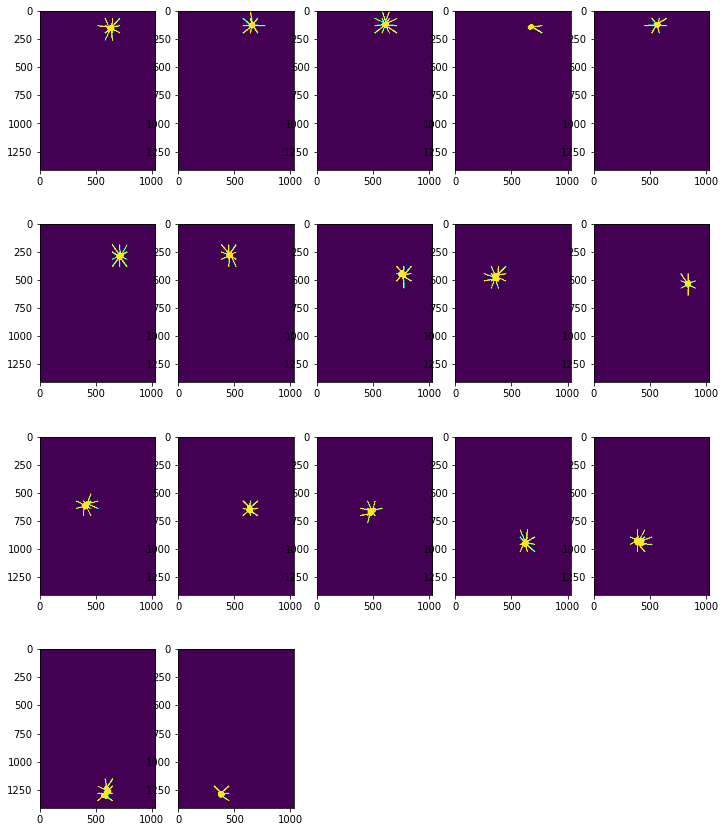

In [33]:
plt.figure(figsize= (12,15))

for i in range(17):
    plt.subplot(4,5,i + 1)
    plt.imshow(cv2.resize(offset_field_img(i,0.5)[:,:,0],(257*4,353*4)))

将所有得分满足阈值要求点的short_offset全部还原后叠加在输入图片上，可以看出基本上很精确地反映了关键点的位置；

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


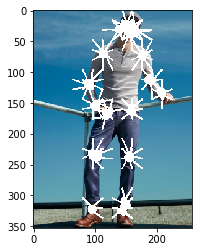

In [34]:
offset_sum = np.zeros(fitted_img.shape,"uint8")
for i in range(17):
    offset_sum += offset_field_img(i,0.5)
    
plt.imshow(fitted_img/255 + offset_sum)

 * 下面的 partNames 定义了人体上17个关键点的名称和顺序；这个顺序与网络输出heatmap和offsetmap的取值一致
 * poseChain 定义了以鼻尖为根节点的肢体树结构，共16条有向边；在取得人体各个关键点的坐标后，点的组织方式是应用决定而不重要的，这里树结构的定义是为了配合网络输出 mid_range_offsets 中的中程偏移向量生成单个人的关键点，并起到区分画面中多个人的作用；其顺序也与网络输出的含义相同

In [35]:
partNames = [
    "nose",
    "leftEye",
    "rightEye",
    "leftEar",
    "rightEar",
    "leftShoulder",
    "rightShoulder",
    "leftElbow",
    "rightElbow",
    "leftWrist",
    "rightWrist",
    "leftHip",
    "rightHip",
    "leftKnee",
    "rightKnee",
    "leftAnkle",
    "rightAnkle"
]

partIDs = {}
for i in range(len(partNames)):
    partIDs[partNames[i]] = i

poseChain = [
    ['nose', 'leftEye'], 
    ['leftEye', 'leftEar'], 
    ['nose', 'rightEye'],
    ['rightEye', 'rightEar'], 
    ['nose', 'leftShoulder'],
    ['leftShoulder', 'leftElbow'], 
    ['leftElbow', 'leftWrist'],
    ['leftShoulder', 'leftHip'],
    ['leftHip', 'leftKnee'],
    ['leftKnee', 'leftAnkle'], 
    ['nose', 'rightShoulder'],
    ['rightShoulder', 'rightElbow'], 
    ['rightElbow', 'rightWrist'],
    ['rightShoulder', 'rightHip'], 
    ['rightHip', 'rightKnee'],
    ['rightKnee', 'rightAnkle']
]

parentChildrenTuple = []
parentToChildEdges = []
childToParentEdges = []

for i in range(len(poseChain)):
    parentChildrenTuple.append([
        partIDs[poseChain[i][0]],
        partIDs[poseChain[i][1]]
    ])
    
    parentToChildEdges.append(partIDs[poseChain[i][1]])
    childToParentEdges.append(partIDs[poseChain[i][0]])                           
    

In [36]:
output_displacement = interpreter.get_tensor(output_detail[2]['index'])

In [37]:
output_displacement.shape

(1, 23, 17, 64)

下面的函数 displacement_field_img 用来绘制每一个满足阈值要求的起始关键点上正向或者反向的中程偏移向量；这些向量经过了 refinement，因此都指向目标关键点中短程偏移指向的具体位置

In [38]:
def displacement_field_img(edge, isBackward, score_threshold):
    channel = 0
    rel = 0
    if isBackward:
        channel = 32
        rel = 1
        
    edge_displacement_img = np.zeros(fitted_img.shape,"uint8")
    
    for i in range(23):
        for j in range(17):
            
            if(output_data[0,i,j,parentChildrenTuple[edge][rel]] > score_threshold):
#                 if isBackward:
#                     print(("displace from ", partNames[parentToChildEdges[edge]], "to" , partNames[childToParentEdges[edge]]))
#                 else:
#                     print(("displace from ", partNames[childToParentEdges[edge]], "to" , partNames[parentToChildEdges[edge]]))
                    
                x_base = j * 16 # 16 is the default stride setting
                y_base = i * 16
                
#                 y_dis = output_displacement[0,i,j,channel + edge]
#                 x_dis = output_displacement[0,i,j,channel + edge + 16]
                
                y_dis = output_displacement[0,i,j, channel + edge ]
                x_dis = output_displacement[0,i,j, channel + edge + 16]
                
                y_tar =(y_base + y_dis)
                x_tar =(x_base + x_dis)
                
                if(0 > y_tar or y_tar > 367 or x_tar > 272 or x_tar < 0):
                    continue
                    
                x_tar_int = int( x_tar / 16 )
                y_tar_int = int( y_tar / 16 )
                
                if isBackward:
                    y_off = int(output_offset[0, y_tar_int, x_tar_int, childToParentEdges[edge]])
                    x_off = int(output_offset[0, y_tar_int, x_tar_int, 17 + childToParentEdges[edge]])
                else:
                    y_off = int(output_offset[0, y_tar_int, x_tar_int, parentToChildEdges[edge]])
                    x_off = int(output_offset[0, y_tar_int, x_tar_int, 17 + parentToChildEdges[edge]])
                
#                 y_off = 0
#                 x_off = 0
                
                y_tar = int(y_tar + round(y_off))
                x_tar = int(x_tar + round(x_off))
                
                cv2.line(edge_displacement_img, (x_base,y_base),(x_tar,y_tar),(250,250,250),1)
                cv2.circle(edge_displacement_img, (x_tar,y_tar), 2, (250,250,250),1)
    return edge_displacement_img



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


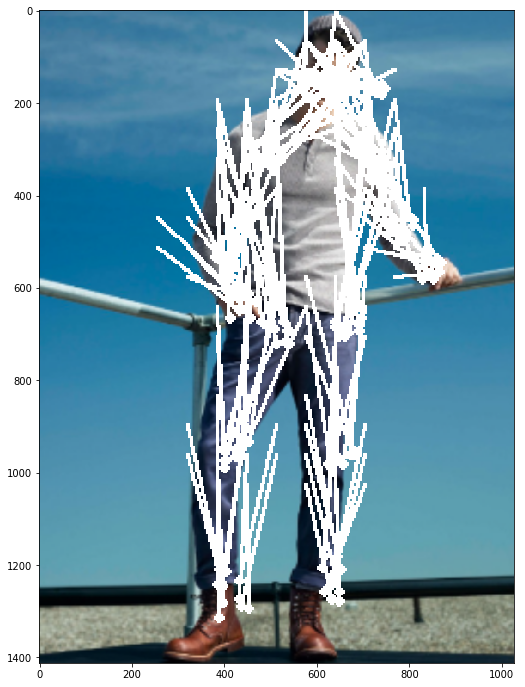

In [39]:
displacement_sum = np.zeros(fitted_img.shape,"uint8")
for i in range(16):
    displacement_sum += displacement_field_img(i,False,0.5)
#     displacement_sum += displacement_field_img(i,True,0.5)
  
plt.figure(figsize = (16,12))
plt.imshow(cv2.resize(fitted_img/255 + displacement_sum,(257*4,353*4)))

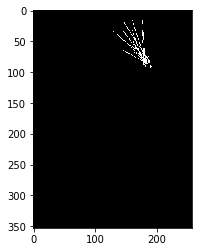

In [40]:
plt.imshow(displacement_field_img(4,False,0.5))

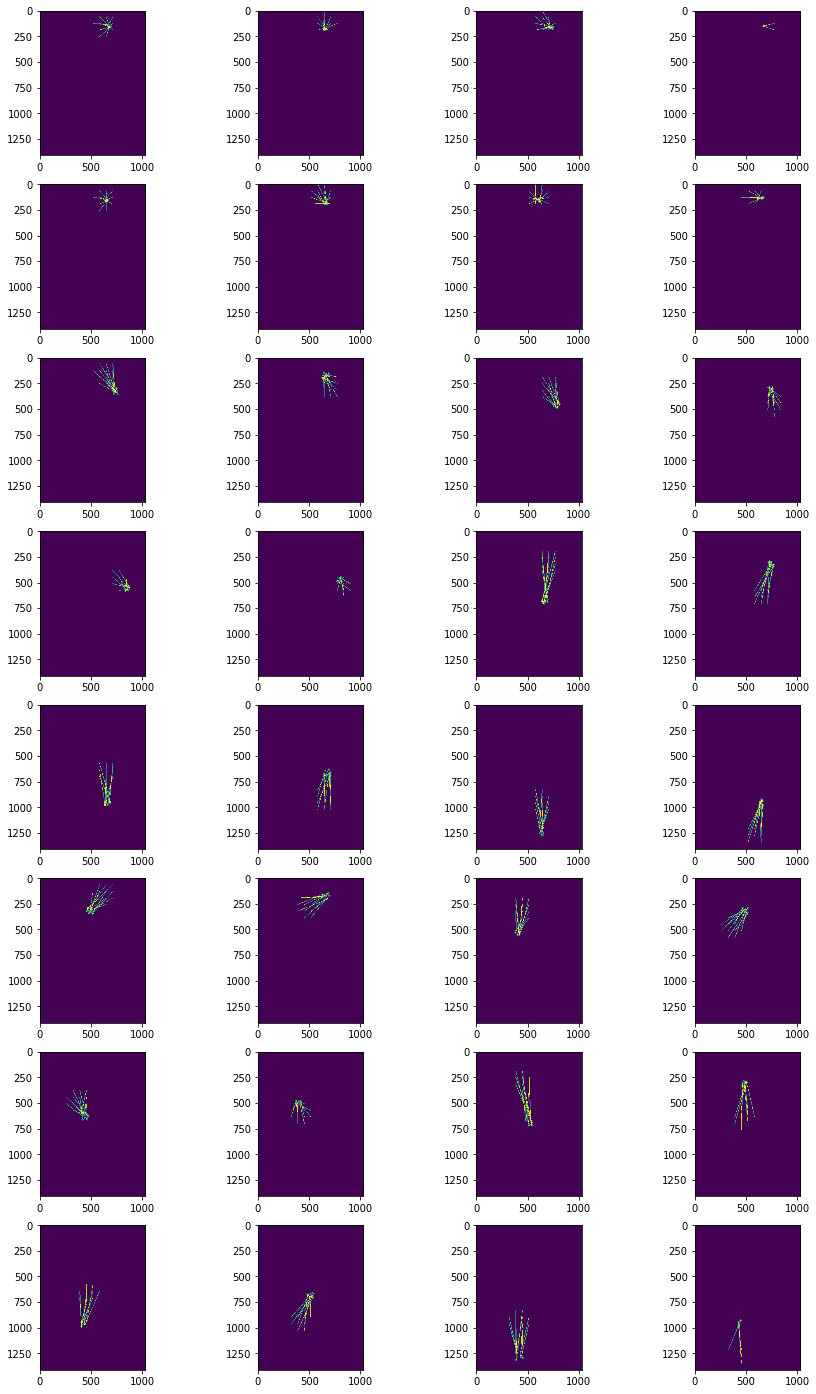

In [41]:
plt.figure(figsize= (15,25))

for i in range(0,16):
    plt.subplot(8,4,i*2 + 1)
    plt.imshow(cv2.resize(displacement_field_img(i,False,0.5)[:,:,0],(257*4,353*4)))
    
    plt.subplot(8,4,i*2 + 2)
    plt.imshow(cv2.resize(displacement_field_img(i,True,0.5)[:,:,0],(257*4,353*4)))

In [42]:
class Part():
    def __init__(self, _heatmapX, _heatmapY, _part_num):
        self.heatmapX = _heatmapX;
        self.heatmapY = _heatmapY;
        self.part_num = _part_num;
    
    def __str__(self):
        return "Part(hX:" + str(self.heatmapX) + ", hY: " + str(self.heatmapY) + ", part: " + str(self.part_num) + ")"
        
class PartWithScore():
    def __init__ (self, _part, _score):
        self.part = _part;
        self.score = _score;
        
    def __lt__(self, other):
        return self.score > other.score
    
    def __str__(self):
        return "PwS(" + self.part.__str__() + ", " + str(self.score) + ")"
    
class Keypoint():
    def __init__(self, _X, _Y, _part_num,_score):
        self.position = (_X, _Y);
        self.part_num = _part_num;
        self.score = _score;
    
    def __str__(self):
        (xx,yy) = self.position
        return "Keypoint[" + str(self.score) + "](X:" + str(xx) + ", Y: " + str(yy) + ", part: " + str(self.part_num) + ")"
    
class Pose():
    def __init__(self):
        self.keypoints = [];
        for i in range(17):
            self.keypoints.append(None);
        self.score = 0.0;
        
    def __str__(self):
        return "Pose[" + str(self.score) + "](" + self.keypoints.__str__() + ")"


接下来实现的是论文中提到的 Fast Greedy Decoding 算法；
1. 首先将heatmap中所有满足阈值要求的关键点都列入一个分值降序的优先队列   *check √*
2. pop出队列首位    *check √*
3. 检测与已经检出的人体关键点是否满足 nms（Non-Maximum Suppression）要求，若不满足直接抛弃
4. 否则，以这个关键点为根分别向上、向下循着中程偏移向量找到个体所有关键点并返回    *check √*

In [43]:
def build_part_queue(threshold):
    part_queue = queue.PriorityQueue()
    
    for i in range(23):
        for j in range(17):
            for p in range(17):
                if(output_data[0,i,j,p]) > 0.5:
                    part_queue.put(PartWithScore(Part(j,i,p),output_data[0,i,j,p]))
    
    return part_queue


In [44]:
part_queue = build_part_queue(0.5)

In [45]:
part_queue.qsize()

170

In [46]:
def within_nms_radius(key_id, nms_squared, poses, root_image_coord):
    for pose in poses:
        if distance_squared(pose.keypoints[key_id].position,root_image_coord) < nms_squared:
            return False
    return True;

STRIDE = 16;

def heatToImgCoord(part_id,heat_coord):
    (x,y) = heat_coord;
    (x_off, y_off) = getOffsetVector(part_id, heat_coord)
    
    return (x * STRIDE + x_off, y * STRIDE + y_off)

def clamp(a, mini, maxi):
    if a < mini:
        return mini
    if a > maxi:
        return maxi
    return int(a)

def imgToHeatCoord(img_coord):
    (x,y) = img_coord;
    return (
        clamp(round(x / STRIDE), 0, 257 - 1),
        clamp(round(y / STRIDE), 0, 353 - 1)
    )
    

def getScore(part_id, heat_pos):
    (heatX,heatY) = heat_pos;
    return output_data[0,heatY,heatX,part_id]

def getOffsetVector(part_id, heat_pos):
    
    (x,y) = heat_pos
    
#     print((x,y,part_id))
    
    y_tar = int(output_offset[0,y,x,part_id])
    x_tar = int(output_offset[0,y,x,part_id + 17])
    
    return (x_tar, y_tar);

def getDisplacement(edge_id, heat_pos, isBackward):
    channel = 0
    if isBackward:
        channel = 32
    
    (x,y) = heat_pos;
    
    return (
        output_displacement[0,y,x, channel + edge_id + 16],
        output_displacement[0,y,x, channel + edge_id]
    )

def traverseToTargetKeypoint( edge_id, source_keypoint, target_keypoint_id, isBackward):
    
    source_keypoint_indecies = imgToHeatCoord(source_keypoint.position);
       
    displacement = getDisplacement(edge_id, source_keypoint_indecies, isBackward);
    
    displacedPoint = (source_keypoint.position[0] + displacement[0] , source_keypoint.position[1] + displacement[1])
    
    displacedPoint_indecies = imgToHeatCoord(displacedPoint);
    
    (x,y) = displacedPoint_indecies
#     print((x,y))
    if((x < 0) or (x >= 17) or (y >= 23) or (y < 0)) :
        return None
    
    offsetVector = getOffsetVector(target_keypoint_id, displacedPoint_indecies)
#     offsetPoint = ( displacedPoint[0] + offsetVector[0] , displacedPoint[1] + offsetVector[1])
    
    score = getScore(target_keypoint_id, displacedPoint_indecies);
    
    targetKeypoint = ( displacedPoint[0] + offsetVector[0], displacedPoint[1] + offsetVector[1])
    
    if isBackward:
        manner = "backward"
    else:
        manner = "forward"
#     print(("traverse" , manner ," find part ", partNames[target_keypoint_id], "through", partNames[source_keypoint.part_num] ))
    
    return Keypoint(int(targetKeypoint[0]), int(targetKeypoint[1]), target_keypoint_id, score);
    
    
    
    

In [47]:
def pose_img(pose):
    img = np.zeros(fitted_img.shape, "uint8")
    for key in pose.keypoints:
        if(key != None):
            cv2.circle(img, key.position, 3, (250,250,250), 1)
            
    for edge in parentChildrenTuple:
        source = pose.keypoints[edge[0]]
        target = pose.keypoints[edge[1]]
        if source != None and target != None:
            cv2.line(img, source.position, target.position, (250,0,250), 2)
        
    return img

def decodePose(root):
    instance = Pose();
    
    rootPart = root.part;
    rootScore = root.score
    
#     print(("[decode pose]","root pose id = ", rootPart.part_num, "which is" , partNames[rootPart.part_num]))
    
    rootPoint = heatToImgCoord(rootPart.part_num,(rootPart.heatmapX,rootPart.heatmapY))
    
    instance.keypoints[rootPart.part_num] = Keypoint(rootPoint[0],rootPoint[1],rootPart.part_num,rootScore)
    
    #Decode the part positions upwards in the tree, following the backward
    
#     count = 1;
#     plt.figure(figsize = (10,10))
    
    edge = 16 - 1
    
#     return instance
    
    while edge >= 0:
        
        sourceKeypointId = parentToChildEdges[edge]
        targetKeypointId = childToParentEdges[edge]
        
        if( (instance.keypoints[sourceKeypointId] != None) and (instance.keypoints[targetKeypointId] == None)):
            instance.keypoints[targetKeypointId] = traverseToTargetKeypoint(
                edge,
                instance.keypoints[sourceKeypointId],
                targetKeypointId,
                True
            )
            
#             plt.subplot(4,5,count)
#             count += 1
#             plt.imshow(pose_img(instance))
        
        edge -= 1
        
    edge = 0
    while edge < 16:
        
        sourceKeypointId = childToParentEdges[edge]
        targetKeypointId = parentToChildEdges[edge]
        
        if( (instance.keypoints[sourceKeypointId] != None) and (instance.keypoints[targetKeypointId] == None)):
            instance.keypoints[targetKeypointId] = traverseToTargetKeypoint(
                edge,
                instance.keypoints[sourceKeypointId],
                targetKeypointId,
                False
            )
        
#         plt.subplot(4,5,count)
#         count += 1
#         plt.imshow(pose_img(instance))
            
        edge += 1
    
    return instance
        
    
    

In [48]:
part_queue = build_part_queue(0.5)
rootPart = part_queue.get()

In [49]:
print(rootPart)

PwS(Part(hX:11, hY: 5, part: 5), 6.657586)


In [50]:
inst = decodePose(rootPart)

In [51]:
print(inst)

Pose[0.0]([<__main__.Keypoint object at 0x12fd5f6d8>, <__main__.Keypoint object at 0x12fd5f978>, <__main__.Keypoint object at 0x12fd5fe80>, <__main__.Keypoint object at 0x12fd5ff60>, <__main__.Keypoint object at 0x133710a90>, <__main__.Keypoint object at 0x12fd5f470>, <__main__.Keypoint object at 0x141054e48>, <__main__.Keypoint object at 0x133710be0>, <__main__.Keypoint object at 0x141054940>, <__main__.Keypoint object at 0x133710438>, <__main__.Keypoint object at 0x13377a860>, <__main__.Keypoint object at 0x13367dac8>, <__main__.Keypoint object at 0x13377a978>, <__main__.Keypoint object at 0x13367d320>, <__main__.Keypoint object at 0x13377abe0>, <__main__.Keypoint object at 0x141054240>, <__main__.Keypoint object at 0x13377a390>])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


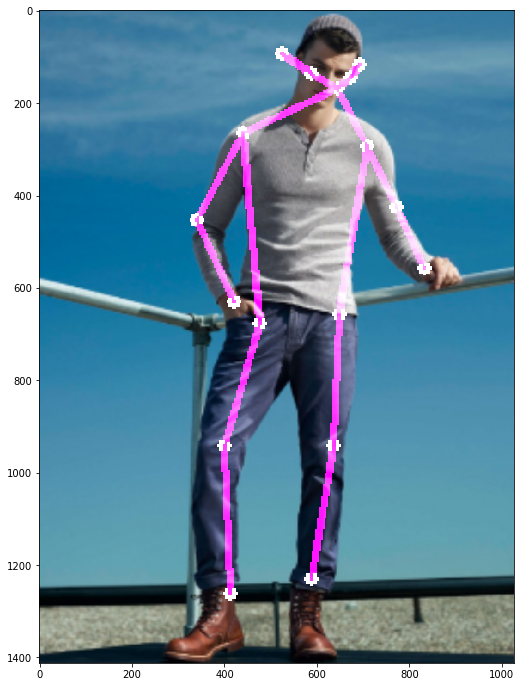

In [52]:
# plt.imshow( fitted_img / 255 + pose_img(inst))
plt.figure(figsize = (16,12))
plt.imshow(cv2.resize(pose_img(inst) + (fitted_img / 255),(257*4,353*4)))

In [53]:
def squaredDistance(a,b):
    (xa,ya) = a
    (xb,yb) = b
    return ((xa - xb) ** 2) + ((ya - yb) ** 2)

def withinNmsRadiusOfCorrespondingPoint(list_of_poses, squaredNms, root_img_coord, part_id):
    for pose in list_of_poses:
        if squaredDistance(pose.keypoints[part_id].position, root_img_coord) < squaredNms:
            return True
    return False

def decodeMultiplePoses(max_detect):
    NMS = 30
    SCORE_THRESHOLD = 0.5
    
    squaredNms = NMS * NMS
    
    part_queue = build_part_queue(SCORE_THRESHOLD)
    
    poses = []
    
    while (len(poses) < max_detect) and (not part_queue.empty()):
        root = part_queue.get()
        
        root_img_coord = heatToImgCoord(root.part.part_num, (root.part.heatmapX, root.part.heatmapY))
        
        if(withinNmsRadiusOfCorrespondingPoint(poses, squaredNms, root_img_coord, root.part.part_num)):
            continue
            
#         print("root not rejected, now length of poses = " + str(len(poses)))
#         for i in range(len(poses)):
              
        
        pose = decodePose(root)
        poses.append(pose)
        
    return poses
    
    
def drawPoses(poses):
    plt.figure(figsize = (16,12))
    count = 1
    for pose in poses:
        plt.subplot(1,len(poses),count)
        plt.imshow(cv2.resize(pose_img(pose) + (fitted_img / 255),(257*4,353*4)))
        count += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


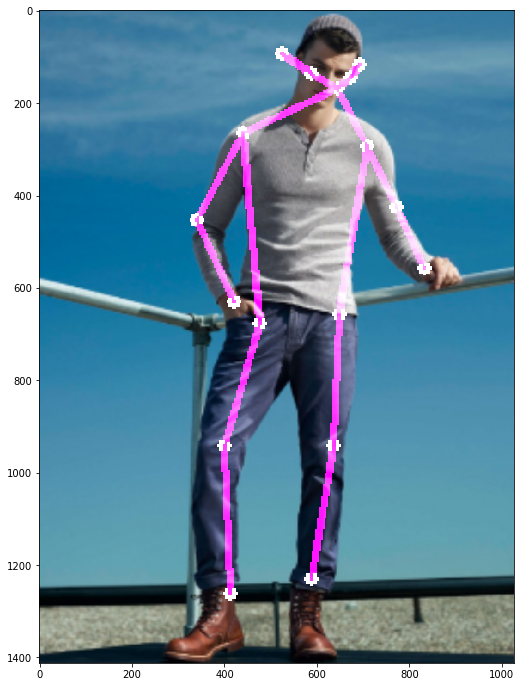

In [54]:
result = decodeMultiplePoses(5)
drawPoses(result)

In [55]:
result